In [288]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import util as ut
from shallowNet.shallowNet import shallowNet
import matplotlib.pyplot as plt 
import copy
import matplotlib.cm as cm




In [289]:
trainY = (ut.generate_training_sat(32,100))[-1]
trainY = trainY.astype(int)

In [287]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense 
        self.activation = tf.keras.activations.get(activation)
        super(DenseTranspose, self).__init__(**kwargs)

    def build(self, batch_input_shape):
        self.b = self.add_weight(name= "bias", shape = [ self.dense.input_shape[-1]], initializer = "zeros")
        self.w = self.dense.weights[0]
        super().build(batch_input_shape)
        
        
    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.w, transpose_b = True)
        return self.activation(z + self.b)

    
    def get_weights(self):
        return {"w": np.shape(tf.transpose(self.w))}    

    @property 
    def weights_transpose(self):
        return tf.transpose(self.dense.weights[0])

class shallowNet:

    @staticmethod
    def build(input_size=32, compression=0.8, reg_cof = 0.01, dropout =0.2):
        assert compression <1 and compression >0, "compression coefficient must be between (0,1)" % compression
        assert dropout <1 and dropout >0, "dropout coefficient must be between (0,1)" % dropout
        
        inputs = Input(shape=(input_size,))
        encoder = Dense(int(input_size * compression),activation="tanh",             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),kernel_regularizer=tf.keras.regularizers.l1(reg_cof))
        decoder = DenseTranspose(dense = encoder)

        #the model 
        x = Dropout(dropout)(inputs)
        encoded = encoder(x)
        decoded = decoder(encoded)
        model = tf.keras.Model(inputs, decoded)
        opt = Adam(lr=0.01)
        model.compile(loss='mse', optimizer=opt)
        model.summary()

        return model

In [4]:
model = shallowNet.build()
H = model.fit(
    x=trainY, y=trainY, 
    epochs = 10, 
    batch_size = 5,
    verbose = 1,
    shuffle = True
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                825       
_________________________________________________________________
dense_transpose (DenseTransp (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4577
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.3395
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.3032
Epoch 4/10
20/20 [======

In [373]:
encoder = tf.keras.Model(inputs = model.input, outputs = [layer.output for layer in model.layers[:3]])
features_list_decoder = model.layers[3]# [layer.output for layer in model.layers[3]]
inputs = Input(encoder.layers[-1].output_shape[-1])
features_list_decoder(inputs)
decoder = tf.keras.Model( inputs = inputs ,outputs = features_list_decoder(inputs))


In [377]:
def code_flip_decode(array, encoder, decoder):
    new_array = encoder(tf.expand_dims(array,0))[-1].numpy().flatten() #encode a sample 
    new_array = np.where(new_array>0, 1,0) # binarize latent representation 
    index = np.random.randint(np.shape(new_array)[-1]) #choose random index to flip 
    new_array[index] = 1 - new_array[index] # apply variation 
    changed_tensor = tf.convert_to_tensor(tmp, dtype = tf.float32) #create new tensor 
    new_tensor = decoder(changed_tensor) # decode the sample with the change from the latent spaece
    output_array = np.where(new_tensor.numpy()[-1]>0.5, 0, 1) # binarize decoded tensor 
    output_tensor = tf.convert_to_tensor(output_array.reshape((1,N)), dtype = tf.float32) # save output tensor
    new_fitness = ut.hiff_fitness(output_array) # calculate transformed tensor fitness
    #print(ut.hiff_fitness(array))
    #print("array", array)
    #print("latent", new_array) 
    #print("out", output_array)
    return output_tensor, output_array, new_fitness

In [394]:
def transfer_sample_latent_flip(array, encoder, decoder):
    N = len(array)
    #array = tf.expand_dims(array,0)
    current_fitness = ut.hiff_fitness(array)
    for i in range(10 *N):
        output_tensor, output_array, new_fitness = code_flip_decode(array, encoder, decoder)
        if new_fitness >= current_fitness: # compare flip with current  fitness 
            current_fitness = new_fitness
            array = output_array
    return array


In [395]:
def generate_new_training_set(initial_training_set, encoder, decoder):
    
    new_trainig_set = []
    normalization_factor = ut.hiff_fitness(np.ones((N,)))

    for array in initial_training_set:
        new_trainig_set.append(transfer_sample_latent_flip(array, encoder, decoder))
    return np.asarray(new_trainig_set, dtype = np.float32)

In [342]:
trainY2 = generate_new_training_set(trainY, encoder, decoder)

In [383]:
model2 = shallowNet.build()
H2 = model.fit(
    trainY2, trainY2, 
    epochs = 10, 
    batch_size = 5,
    verbose = 1,
    shuffle = True
)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_transpose_9 (DenseTran (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2296
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2296
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2293
Epoch 4/10
20/20 [===

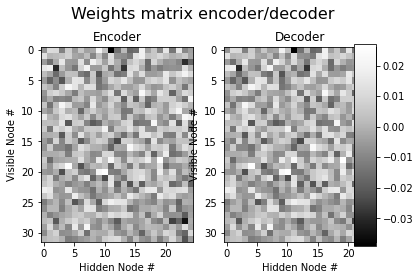

In [384]:
def plot_weights_mode(model, path):
    fig, axs = plt.subplots(1,2,constrained_layout=True)
    fig.suptitle('Weights matrix encoder/decoder', fontsize=16)
    fig.subplots_adjust(hspace =0.7)
    pcm = axs[0].imshow(model2.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[0].set_title("Encoder")
    axs[0].set_ylabel("Visible Node #")
    axs[0].set_xlabel("Hidden Node #")

    pcm=axs[1].imshow(model2.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[1].set_title("Decoder")
    axs[1].set_ylabel("Visible Node #")
    axs[1].set_xlabel("Hidden Node #")
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(pcm, cax=cbar_ax)
    plt.savefig("weights_plot_model_2.png")
    plt.show()
plot_weights_mode(model2, "weights_plot_model_2.png")

In [385]:
def generate_evolution_plot(encoder, decoder, array, path = "solution_development_plot_2.png", learning_steps = 50):
    N = np.shape(array)[-1] # size of the array 
    index = np.random.randint(np.shape(array)[0]) #choose random index to flip 
    candidate_solution = array[index]# pick up random sample 
    sol_evol = [] # list to store steps of evolution 
    sol_evol.append(candidate_solution)
    current_fittnes = ut.hiff_fitness(candidate_solution)
    print(candidate_solution)
    for i in range(learning_steps-1):
        new_candidate_sol = copy.copy(candidate_solution)
        output_tensor, output_array, new_fitness = code_flip_decode(new_candidate_sol, encoder, decoder)
        if new_fitness >= current_fittnes:
            candidate_solution = output_array 
            current_fittnes = new_fitness
        sol_evol.append(candidate_solution)

    tmp = np.array(sol_evol)
    plt.figure()
    plt.imshow(tmp, interpolation='nearest', cmap=cm.Greys_r)
    plt.title("Solution Development at Evolution Step 1")
    plt.xlabel("Solution variable")
    plt.ylabel("Development Step")
    plt.colorbar()
    plt.savefig(path)
    plt.show()


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0]


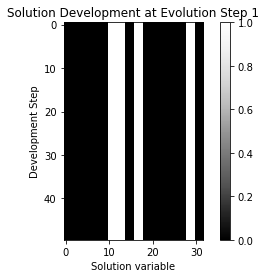

In [386]:
generate_evolution_plot(encoder, decoder, trainY)

In [392]:

def generate_trajectory_plot(encoder, decoder, array, target_size = 10 ,path = "trajectory_plot_2.png", learning_steps = 70):    
    X = np.arange(learning_steps)
    normalization_factor = ut.hiff_fitness(np.ones((np.shape(array)[-1],)))
    trajectory_samples = []
    plt.figure()
    plt.title("Example Solution Trajectory 2 at Evolution Step 1")
    for k in range(target_size):
        current_array = array[k]
        current_fitness = ut.hiff_fitness(current_array)
        current_target_trajectory = []
        current_target_trajectory.append(current_fitness/normalization_factor)
        for i in range(learning_steps-1):
            output_tensor, output_array, new_fitness = code_flip_decode(current_array, encoder, decoder)
            if new_fitness >= current_fitness:
                current_fitness = new_fitness
                current_array = output_array
                current_target_trajectory.append(new_fitness/normalization_factor)
            else:
                current_target_trajectory.append(current_target_trajectory[-1])
        trajectory_samples.append(current_target_trajectory)
        plt.plot(X, np.asarray(current_target_trajectory))
    plt.xlabel("learning step")
    plt.ylabel("fitness \ max_fitness")
    plt.savefig(path)
    return trajectory_samples
    

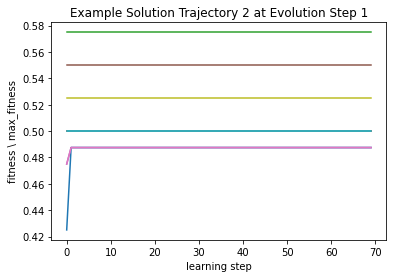

In [393]:
samples = generate_trajectory_plot(encoder, decoder, trainY)